In [1]:
import pandas as pd
import numpy as np
import os

import Utils as utils

import matplotlib
matplotlib.use('MacOSX')
%matplotlib inline
from matplotlib import pyplot as plt

PATH = '~/Desktop/Projects/Virality_Predictor/datasets'

In [2]:
def load_shared_articles(file_name):
    ''' Loads the articles data
    Args:
        file_name: Articles file name, .csv
        lang: Desired article language, str
    Returns:
        df
    '''
    articles_file = os.path.join(PATH, file_name)
    original_df = pd.read_csv(articles_file)
    
    # Get only 'shared' articles
    df = original_df[original_df['eventType'] == 'CONTENT SHARED']
    
    # Drop columns that not used in this work
    df.drop(columns = ['url','timestamp','eventType','authorPersonId','authorSessionId','authorUserAgent','authorRegion','authorCountry'], inplace = True)
    df.set_index('contentId', inplace=True)
    return df


In [3]:
def load_user_interactions_with_weekday(file_name):
    ''' Loads the users data, calculates virality per person, per article. Adds information about weekday activity
    Args:
        file_name: Articles file name, .csv
        articles: Indices of articles not removed, Series
        normalize: Normalizes virality values. Boolean
        
    Returns:
        df
    '''
    users_file = os.path.join(PATH, 'users_interactions.csv')
    original_df = pd.read_csv(users_file)
    
    # Change eventType strings to virality values based on event weights
    article_importance = {"VIEW": 1, "LIKE": 4, "COMMENT CREATED": 10, "FOLLOW": 25, "BOOKMARK": 100}
    original_df["virality"] = original_df["eventType"].apply(lambda x: article_importance[x])
    original_df.drop(columns = ['eventType'])

    # Convert timestamp to date_time
    original_df['date_time'] =pd.to_datetime(original_df['timestamp'], unit='s')

    # Add a new column to see whether the users are active in weekdays or not
    original_df['weekday'] = ((pd.DatetimeIndex(original_df['date_time']).dayofweek) // 5 == 0).astype(float)
    
    df = original_df.groupby(['personId', 'contentId', 'weekday'])['virality'].sum().reset_index()
        
    df = df[['virality', 'contentId', 'personId', 'weekday']]
    
    return df

In [4]:
# Load articles data
shared_articles_df = load_shared_articles('shared_articles.csv')

/Users/mirayyuce/.virtualenvs/thesis/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [5]:
# Load users' data. Not the original set. We only use personId, contentId and virality
user_interactions_df = load_user_interactions_with_weekday('users_interactions.csv')

In [6]:
print('Are there any duplicate users?')
user_interactions_df['personId'].nunique() != len(user_interactions_df.groupby('personId'))

Are there any duplicate users?


False

In [7]:
print('Number of users')
user_interactions_df['personId'].nunique()

Number of users


1895

In [8]:
print('General inspection on data')
user_interactions_df.describe(include='all')

General inspection on data


,virality,contentId,personId,weekday
count,41164.000000,4.116400e+04,4.116400e+04,41164.000000
mean,9.271475,-6.027265e+16,-4.642620e+16,0.957973
std,50.013610,5.375209e+18,5.100094e+18,0.200653
min,1.000000,-9.222795e+18,-9.223122e+18,0.000000
25%,1.000000,-4.765712e+18,-3.954277e+18,1.000000
50%,1.000000,-1.456927e+16,-8.938893e+16,1.000000
75%,2.000000,4.555339e+18,3.829785e+18,1.000000
max,7680.000000,9.222265e+18,9.210531e+18,1.000000


In [9]:
print('Get users interacted only with the shared articles')
user_interactions_df = pd.merge(user_interactions_df, shared_articles_df, on = 'contentId', how='inner')
    

Get users interacted only with the shared articles


In [10]:
print('General inspection on data')
user_interactions_df.describe(include='all')

General inspection on data


,virality,contentId,personId,weekday,contentType,title,text,lang
count,41136.000000,4.113600e+04,4.113600e+04,41136.000000,41136,41136,41136,41136
unique,NaN,NaN,NaN,NaN,3,2938,2947,5
top,NaN,NaN,NaN,NaN,HTML,Former Google career coach shares a visual tri...,"If you want 2017 to be an exciting year, desig...",en
freq,NaN,NaN,NaN,NaN,40973,270,270,26551
mean,9.276741,-6.080664e+16,-4.582332e+16,0.957944,NaN,NaN,NaN,NaN
std,50.030217,5.376133e+18,5.100254e+18,0.200719,NaN,NaN,NaN,NaN
min,1.000000,-9.222795e+18,-9.223122e+18,0.000000,NaN,NaN,NaN,NaN
25%,1.000000,-4.765712e+18,-3.954277e+18,1.000000,NaN,NaN,NaN,NaN
50%,1.000000,-1.456927e+16,-8.938893e+16,1.000000,NaN,NaN,NaN,NaN
75%,2.000000,4.556294e+18,3.829785e+18,1.000000,NaN,NaN,NaN,NaN


In [11]:
print('Event type information. We will not use removed articles')
user_interactions_df.groupby(['lang']).size()

Event type information. We will not use removed articles


lang
en    26551
es        6
ja       23
la       26
pt    14530
dtype: int64

In [12]:
print('Content type information')
user_interactions_df.groupby(['contentType']).size()

Content type information


contentType
HTML     40973
RICH        71
VIDEO       92
dtype: int64

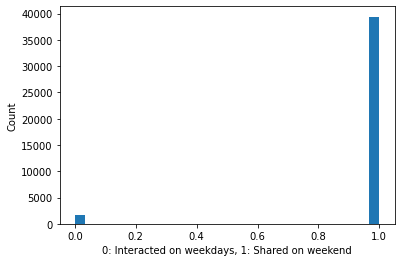

In [13]:
weekday_df = user_interactions_df['weekday']
plt.hist(weekday_df, 30)
plt.xlabel("0: Interacted on weekdays, 1: Shared on weekend")
plt.ylabel("Count")
plt.show()

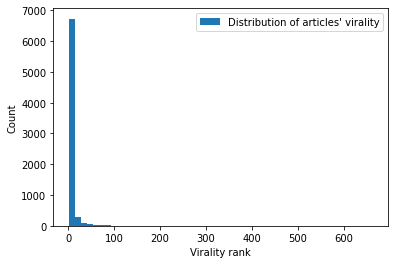

In [14]:
virality = user_interactions_df.groupby('personId')['virality'].value_counts().sort_index(ascending=False)
#bins = np.linspace(-10, 10, 100)
plt.hist(virality, 50, label="Distribution of articles' virality")
plt.legend(loc='upper right')
plt.xlabel("Virality rank")
plt.ylabel("Count")
plt.show()

In [15]:
print('The most active users')
user_interactions_df_raw_agg = user_interactions_df.groupby(['personId']).agg({'virality':sum})
user_interactions_df_raw_agg.reset_index().sort_values('virality', ascending=False)[:10]

The most active users


,personId,virality
858,-709287718034731589,34480
831,-1032019229384696495,13291
1286,3302556033962996625,6945
1020,801895594717772308,5675
1344,3829784524040647339,5222
541,-4028919343899978105,5180
798,-1443636648652872475,5056
781,-1616903969205976623,4286
1063,1116121227607581999,3910
1867,8968131284214320024,3702


In [16]:
print('The least active users')
user_interactions_df_raw_agg.reset_index().sort_values('virality', ascending=True)[:10]

The least active users


,personId,virality
1318,3603734003549693385,1
910,-270546895637819286,1
902,-318015038957279230,1
259,-6594283959918506908,1
1507,5569732571503995928,1
1508,5573804063428996341,1
890,-437375666128963453,1
130,-7966002439899518762,1
483,-4543093052611851269,1
256,-6624483529135402208,1


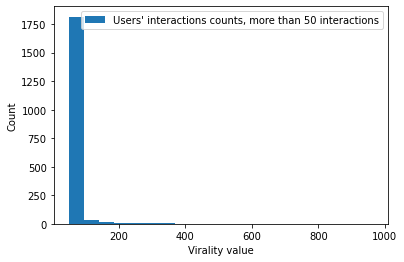

In [17]:
data = user_interactions_df.groupby('personId')['virality'].count().clip(lower=50)
plt.hist(data, 20, label="Users' interactions counts, more than 50 interactions")
plt.legend(loc='upper right')
plt.xlabel("Virality value")
plt.ylabel("Count")
plt.show()

In [18]:
# Articles in EN and PT
shared_articles_df_EN = utils.filter_articles_in_lang(shared_articles_df, ['en'])
shared_articles_df_PT = utils.filter_articles_in_lang(shared_articles_df, ['pt'])

In [19]:
print('Get users interacted only with EN and PT')
user_interactions_df_EN = pd.merge(user_interactions_df, shared_articles_df_EN, on = 'contentId', how='inner')
user_interactions_df_PT = pd.merge(user_interactions_df, shared_articles_df_PT, on = 'contentId', how='inner')
    

Get users interacted only with EN and PT


In [20]:
print('General information about users who interacted with articles in English')
user_interactions_df_EN.describe(include='all')

General information about users who interacted with articles in English


,virality,contentId,personId,weekday,contentType_x,title_x,text_x,lang_x,contentType_y,title_y,text_y,lang_y
count,26551.000000,2.655100e+04,2.655100e+04,26551.000000,26551,26551,26551,26551,26551,26551,26551,26551
unique,NaN,NaN,NaN,NaN,3,2113,2121,1,3,2113,2121,1
top,NaN,NaN,NaN,NaN,HTML,Former Google career coach shares a visual tri...,"If you want 2017 to be an exciting year, desig...",en,HTML,Former Google career coach shares a visual tri...,"If you want 2017 to be an exciting year, desig...",en
freq,NaN,NaN,NaN,NaN,26459,270,270,26551,26459,270,270,26551
mean,10.213438,-6.010794e+16,-1.154160e+16,0.950962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,59.986465,5.398191e+18,5.028636e+18,0.215951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,-9.192549e+18,-9.223122e+18,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.000000,-4.814871e+18,-3.596627e+18,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.000000,6.505332e+16,-1.088422e+17,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.000000,4.579558e+18,3.743262e+18,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
print('Number of users - EN')
user_interactions_df_EN['personId'].nunique()

Number of users - EN


1644

In [22]:
print('General information about users who interacted with articles in Portuguase')
user_interactions_df_PT.describe(include='all')

General information about users who interacted with articles in Portuguase


,virality,contentId,personId,weekday,contentType_x,title_x,text_x,lang_x,contentType_y,title_y,text_y,lang_y
count,14530.000000,1.453000e+04,1.453000e+04,14530.000000,14530,14530,14530,14530,14530,14530,14530,14530
unique,NaN,NaN,NaN,NaN,3,818,819,1,3,818,819,1
top,NaN,NaN,NaN,NaN,HTML,"Novo workaholic trabalha, pratica esportes e t...",Novo workaholic não abre mão do esporte e da f...,pt,HTML,"Novo workaholic trabalha, pratica esportes e t...",Novo workaholic não abre mão do esporte e da f...,pt
freq,NaN,NaN,NaN,NaN,14459,195,195,14530,14459,195,195,14530
mean,7.577564,-4.006562e+16,-1.077596e+17,0.970681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,22.473596,5.328190e+18,5.226964e+18,0.168704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,-9.222795e+18,-9.223122e+18,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.000000,-4.615179e+18,-4.298178e+18,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.000000,-1.331393e+17,-4.816180e+16,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.000000,4.383036e+18,3.915038e+18,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
print('Number of users - PT')
user_interactions_df_PT['personId'].nunique()

Number of users - PT


1619